# Geovisualización de la actividad económica en México

**Autor:** Victor Hugo Hernández García

Proyecto para el curso de Programación de la Maestría en Análisis Estadístico y Computación

## Introducción

El objetivo de este proyecto es crear un programa que genere mapas con la distribución de la actividad económica en el territorio nacional y permita resaltar las zonas de alta concentración.

La fuente de información primordial para este trabajo es el Directorio Estadístico de Unidades Económicas (DENUE). El DENUE cuenta con una herramienta de visualización integrada en el sitio del INEGI que permite ver cada establecimiento como un punto en un mapa. Sin embargo, esta visualización oculta en muchas ocasiones la densidad de los establecimientos cuando se hacen mapas con un nivel de zoom amplio. En muchos casos, en el mapa vemos un sólo punto, pero en relaidad hay cientos de puntos encimados unos encima de otros. Es por ello que se requiere de un modo de visualización que tome en cuenta la densidad de puntos.

El DENUE ofrece los datos de identificación, ubicación, actividad económica y tamaño de más de 5 millones de unidades económicas activas en el territorio nacional. Las variables de interés para este proyecto son:

* Actividad según el clasificador SCIAN
* Tamaño del establecimiento (personal ocupado)
* Latitud
* Longitud

La propuesta metodológica para medir la densidad de puntos es mediante Estimaciones de Kernel de Densidad, o KDE por sus siglas en inglés. Dos referencias útiles sobre su aplicación en Python a datos geográficos se encuentran a continuación:

* https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b
* https://www.cienciadedatos.net/documentos/pystats02-kernel-density-estimation-kde-python.html


## Descripción del algoritmo

---
`MapaDENUE(scian, region, puntos, nivelMin)`

**Entradas:**
* `scian`: *string* que representa el código del clasificador SCIAN de las actividades que se desean graficar. Debe contener entre 1 y 6 caracteres.
* `region`: *string* que representa la clave de la entidad federativa de donde se desea hacer la gráfica. La entrada por default es "*", lo cual resulta en un mapa a nivel nacional.
* `puntos`: *bool* que indica si deben graficarse los puntos individuales, además de las curvas de nivel. Por default, no se grafican los puntos.
* `nivelMin`: *float* en el intervalo (0,1) que indica la curva de nivel más pequeña que debe graficarse. Si nivelMin=0.5, se graficarán las curvas de nivel que contienen el 50% de la distribución más concentrada. Su valor por defaul es 0.05

**Pseudocódigo**

1. Convertir `scian` a string.
2. Realizar consulta a la base de datos en formato SQLITE.
3. Realizar transformaciones necesarias a los datos.
4. Calcular y graficar la distribución kernel ponderada de los datos.
5. Obtener la imágen del mapa subyacente a los datos.
6. Desplegar el mapa para el usuario.
---

Se propone la creación de tres funciones auxiliares para modularizar y simplificar el proceso.

---
`DENUE_SQL(scian, region)`

**Entradas:**
* `scian`: *string* que representa el código del clasificador SCIAN de las actividades que se desean graficar. Debe contener entre 1 y 6 caracteres.
* `region`: *string* que representa la clave de la entidad federativa de donde se desea hacer la gráfica. La entrada por default es "*", lo cual resulta en un mapa a nivel nacional.

**Pseudocódigo**

1. Crea la conexión con la base de datos
2. Hace una consulta SQL con base en los parámetros pasados a la función.

     a. Si `region` == "*", selecciona longitud, latitud y per_ocu donde codigo_act == `scian`
     
     b. Si `region` != "*", selecciona longitud, latitud y per_ocu donde codigo_act == `scian` y cve_ent == `region`
3. Transforma el objeto a un dataframe de pandas, para facilitar el manejo posterior.
4. Regresa un dataframe con tres variables: longitud, latitud y número de personas ocupadas por el establecimiento.
---
---
`SustituirPesos(datos)`

**Entradas:**
* `datos`: *dataframe* que contiene tres variables (longitud, latitud y peso de cada punto).

**Pseudocódigo**

1. Declara un conjunto de reglas que sustituyen las cadenas de "rangos de personal ocupado" por valores numéricos, en una estructura tipo diccionario
2. Reemplaza las cadenas por los valores numéricos correspondientes.
3. Regresa un datagrame nuevo con valores numéricos como peso de cada punto.
---
---
`Graficar(datos, puntos, nivelMin)`

**Entradas:**
* `datos`: *dataframe* que contiene tres variables (longitud, latitud y peso de cada punto).
* `puntos`: *bool* que indica si deben graficarse los puntos individuales, además de las curvas de nivel. Por default, no se grafican los puntos.
* `nivelMin`: *float* en el intervalo (0,1) que indica la curva de nivel más pequeña que debe graficarse. Si nivelMin=0.5, se graficarán las curvas de nivel que contienen el 50% de la distribución más concentrada. Su valor por defaul es 0.05

**Pseudocódigo**

1. Cálculo del kdeplot, basado en los datos, utilizando los ponderadores y el nivel mínimo para las curvas de nivel, como parámetro. Se utiliza la librería seaborn para hacer la gráfica.
2. Si puntos == True, se añade un gráfico de dispersión con los datos sobre las curvas de nivel.
3. Se añade la imágen del mapa correspondiente a la visualización mediante contextily.
---


## Experimentos/discusión

El primer requisito para que este código funcione es tener acceso a la base de datos del DENUE. En este caso, se está trabajando con el DENUE actualizado a noviembre del 2021. Esta base de datos fue creada en SQLite a partir de 25 archivos en formato CSV, descargados de [este sitio del INEGI](https://inegi.org.mx/app/descarga/).

La base de datos integrada, [disponible para descarga en este link](https://drive.google.com/file/d/1cxPTIAwOijqycsleTTNgc74GBIpQhdeC/view?usp=sharing), contiene 5.5 millones de observaciones y 42 variables que identifican al establecimiento y lo geolocalizan. Este archivo, con extensión .db pesa 4.4 GB. Es por ello que, para hacer múltiples consultas y filtrado de los datos, es necesario manejar el DENUE en SQL, y no cargado directamente en Python.

A continuación, se muestran las librerías requeridas por este proyecto. Destaca el uso de sqlite3 para hacer la conexión con la bse de datos y obtener los datos.

También es importante el uso de seaborn, dado que tiene implementada la función kdeplot, la cual toma en consideración los pesos específicos de cada punto en el mapa.

Por último, contextily es empleado para obtener las imágenes de los mapas que aparecen como fondo de las visualizaciones. Estas imágenes son obtenidas mediante una conexión a APIs públicas y gratuitas.

In [47]:
### Librerías ###

# Se utiliza sqlite3 para generar una 
# conexión con una base de datos y obtener los datos en formato SQL.
import sqlite3
# pyplot y seaborn son necesarios para generar las gráficas de 
# kernel a partir d elos datos
import matplotlib.pyplot as plt
import seaborn
# contextily obtiene las imágenes de los mapas sobre los cuales 
# se sobreponen los gráficos de kernel
import contextily
# pandas ayuda a transformar la información con mayor facilidad
import pandas

Empezamos por verificar la conexión a la base de datos mediante una consulta sencilla:

In [61]:
sqlcon = sqlite3.connect("denue.db")
cursor = sqlcon.cursor()
query = "SELECT  count(per_ocu) FROM denue" 
cursor.execute(query)
cursor.fetchall()

[(5529201,)]

Con el resultado anterior, verificamos que la base de datos del DENUE cuenta con más de 5.5 millones de establecimientos registrados.

A continuación, hacemos un nuevo query, buscando esta vez el número de establecimientos por estado.

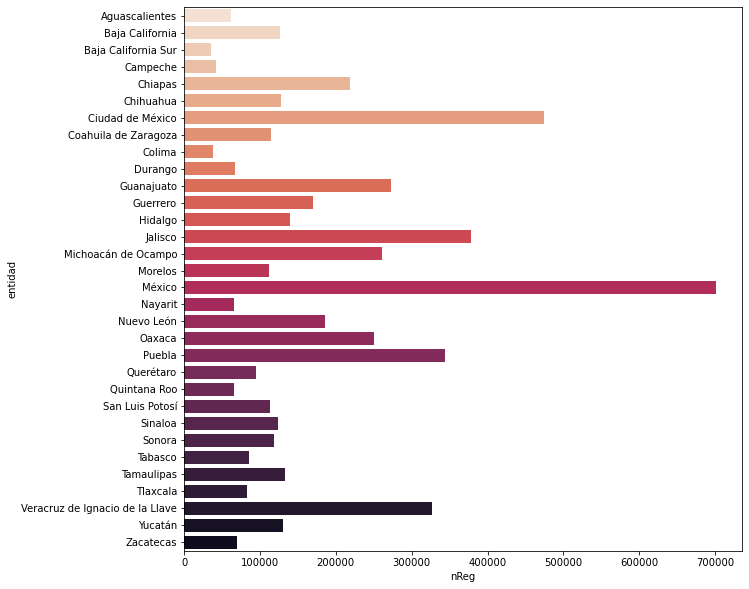

In [62]:
sqlcon = sqlite3.connect("denue.db")
cursor = sqlcon.cursor()
query = "select DISTINCT entidad, count(entidad) from denue GROUP by entidad" 
cursor.execute(query)
res = pandas.DataFrame(cursor.fetchall(),columns=("entidad","nReg"))
f, ax = plt.subplots(ncols=1, figsize=(10,10))
seaborn.barplot(x = "nReg", y="entidad", data=res, palette="rocket_r")
plt.show()

Podemos observar que la entidad con más establecimientos económicos en el DENUE es el Estado de México, seguido de la CDMX, Jalisco, Puebla y Veracruz.

A continuación, mostramos la implementación de la función que realiza la consulta a la base de datos en formato SQL. Esta función recibe como parámetros dos strings. La primera se refiere al código SCIAN de la actividad que va a graficarse, y la segunda se refiere al código que identifica la entidad federativa de la que se quiere obtener un mapa.

In [50]:
# Función para hacer consultas en SQL
def DENUE_SQL(scian, region):
    # Se añade el signo % para considerar las subclasificaciones del SCIAN
    # introducido. Por ejemplo, si el usuario usa el código "55", se seleccionarán todos
    # los establecimientos cuyo código SCIAN inicia en "55"
    scian2 = scian + "%"
    # Conexión a la base de datos
    sqlcon = sqlite3.connect("denue.db")
    cursor = sqlcon.cursor()
    # Hay dos opciones de consulta, dependiendo de si se hará un mapa
    # nacional (region == "*"), o un mapa estatal.
    if region == "*":
        query = "SELECT  latitud, longitud, per_ocu from denue WHERE codigo_act LIKE ?" 
        cursor.execute(query, (scian2,))
    else:
        query = "SELECT  latitud, longitud, per_ocu from denue WHERE codigo_act LIKE ? AND cve_ent == ?" 
        cursor.execute(query, (scian2,region))
    # Se obtienen los datos y se convierten en un dataframe de pandas
    res = cursor.fetchall()
    res = pandas.DataFrame(res, columns = ("latitud","longitud","per_ocu"))
    return res

resQ = DENUE_SQL("336", "*")
print("Esta consulta devolvió "+str(len(resQ))+" resultados")
resQ.head()

Esta consulta devolvió 3570 resultados


latitud    longitud             per_ocu
0  21.923729 -102.335145     6 a 10 personas
1  22.036633 -102.277274    31 a 50 personas
2  21.873717 -102.334303      0 a 5 personas
3  21.746180 -102.279254  101 a 250 personas
4  21.726153 -102.321033   51 a 100 personas

En este paso, se cuenta con las coordenadas en el formato correcto para el análisis. Sin embargo, el número de personas ocupadas aún es unsa cadena de texto, por lo que no podemos usarla directamente como ponderadores de la distribución kernel.

La siguiente función se encarga de sustituir las cadenas por valores numéricos relacionados. Para cada intervalo de personas ocupadas, se tomó el límite inferior. La única excepción es el bloque de 0 a 5 personas, para el cual se tomó por default el valor de uno. Los valores a sustituirse se encuentran en un objeto de tipo diccionario, lo cual facilita el reemplazo de información mediatne las funciones del dataframe de pandas.

In [63]:
# Función para cambiar el per_ocu tipo cadena, por números
def SustituirPesos(datos):
    # Se declara el diccionario de datos para hacer la sustitución
    diccSust = {'0 a 5 personas': 1, '6 a 10 personas': 6,
                '11 a 30 personas': 11,'31 a 50 personas':31, 
                '51 a 100 personas':51,'101 a 250 personas':101, 
                '251 y más personas':201}
    # Se hace el reemplazo y se regresa el resultado.
    return datos.replace({"per_ocu": diccSust})

datosW = SustituirPesos(resQ)
datosW.head()

latitud    longitud  per_ocu
0  21.923729 -102.335145        6
1  22.036633 -102.277274       31
2  21.873717 -102.334303        1
3  21.746180 -102.279254      101
4  21.726153 -102.321033       51

Del resultado de la celda anterior, podemos observar que la sustitución se hizo con éxito.

La tercera función auxiliar se encarga de hacer el gráfico y configurar los aspectos de estilo. La entrada son el dataframe de datos, así como dos parámetros que determinan si se hará un gráfico combinado de kernel con puntos, y un parámetro que indica el nivel mínimo de la distribución de establecimientos que se resaltará en el mapa. Esta función se basa en rutinas de las librerías seaborn, para la distribución kernel y estilo del gráfico, y la librería contextily, para la obtención de las imágenes del mapa.

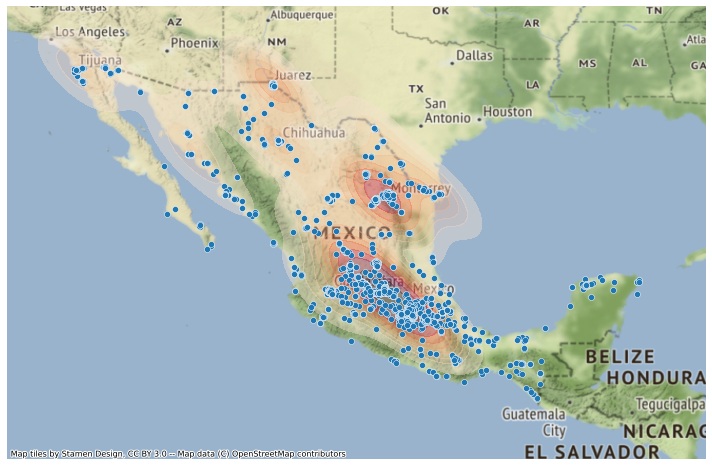

In [64]:
# Función para hacer el gráfico del mapa, una vez que el dataframe está listo.
def Graficar(datos, puntos = False, nivelMin = 0.05):
    f, ax = plt.subplots(ncols=1, figsize=(10,10))
    # Creación del kdeplot
    kde = seaborn.kdeplot(
        ax = ax,
        # Coordenadas de los puntos
        x = datos["longitud"],
        y = datos["latitud"],
        # Pesos para cada punto
        weights = datos["per_ocu"],
        # Se asigna el valor m´nimo a graficar.
        thresh = nivelMin,
        # Parámetros de estilo gráfico
        shade = True,
        alpha = 0.4,
        cmap = "rocket_r"
    )
    # Se incluye una rutina opcional, que depende del parámetro "puntos"
    if puntos:
        seaborn.scatterplot(ax = ax,
            x = datos["longitud"],
            y = datos["latitud"]
        )

# Se descarga y añade la imágen del mapa al fondo de la densidad kernel.
    contextily.add_basemap(ax = ax,crs = "WGS84", source = contextily.providers.Stamen.Terrain)
    ax.set_axis_off()
    plt.tight_layout()

    plt.show()

Graficar(datosW, puntos = True)

Por último, implementamos la función principal, la cual asu vez llama a las tres funciones previas.

La consulta contiene: 3570 establecimientos


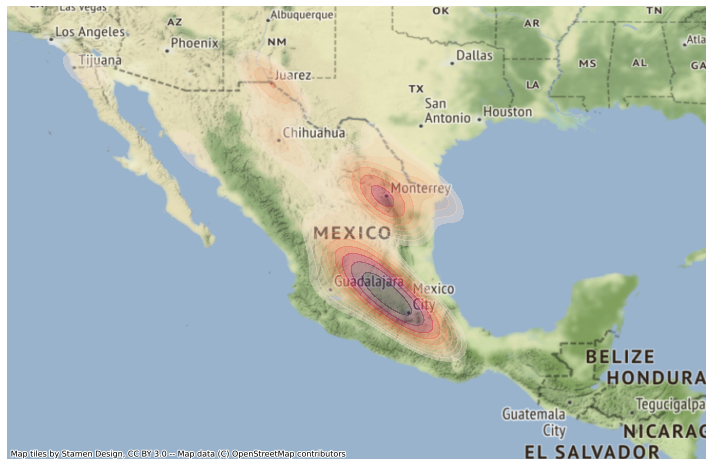

In [67]:
def MapaDENUE(scian, region = "*", puntos = False, nivelMin = 0.05):
    scian = str(scian)
    resQ = DENUE_SQL(scian, region)
    print("La consulta contiene: "+str(len(resQ))+" establecimientos")
    datosW = SustituirPesos(resQ)
    Graficar(datosW, puntos = puntos, nivelMin=nivelMin)

MapaDENUE("336", region = "*", puntos = False, nivelMin = 0.2)

El mapa anterior muestra la distribución de los establecimientos dedicados a la fabricación de equipo de transporte. Este mapa permite identificar que esta actividad está concentrada en la región central de México y alrededor de la ciudad de Monterrey. 

La función también nos permite ver mapas específicos por estado, como el que se muestra a continuación de la Ciudad de México, para empresas que ofrecen consultoría administrativa, científica y técnica:

La consulta contiene: 1947 establecimientos


La consulta contiene: 1947 establecimientos


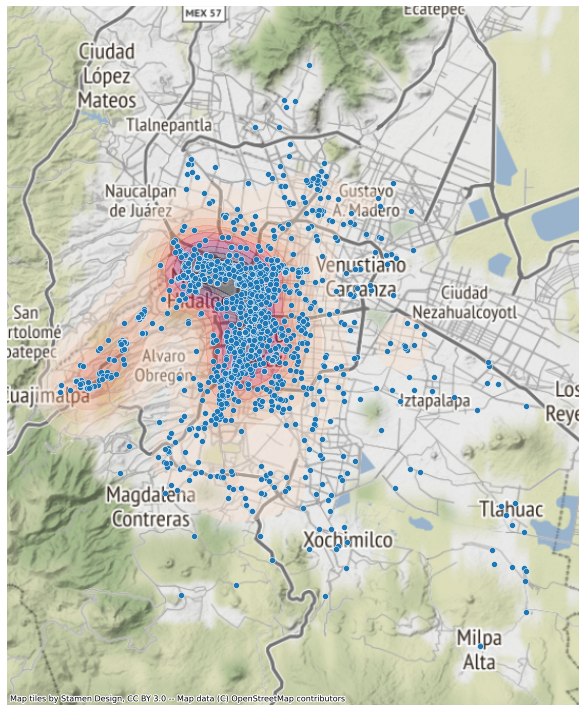

In [71]:
MapaDENUE("5416",region="09")
MapaDENUE("5416",region="09", puntos=True)

La relevancia de visualizar estos datos como densidades y no como simples puntos, puede verificarse con el siguiente ejemplo de restaurantes con servicio de preparación de alimentos a la carta o de comida corrida.

La consulta contiene: 8583 establecimientos


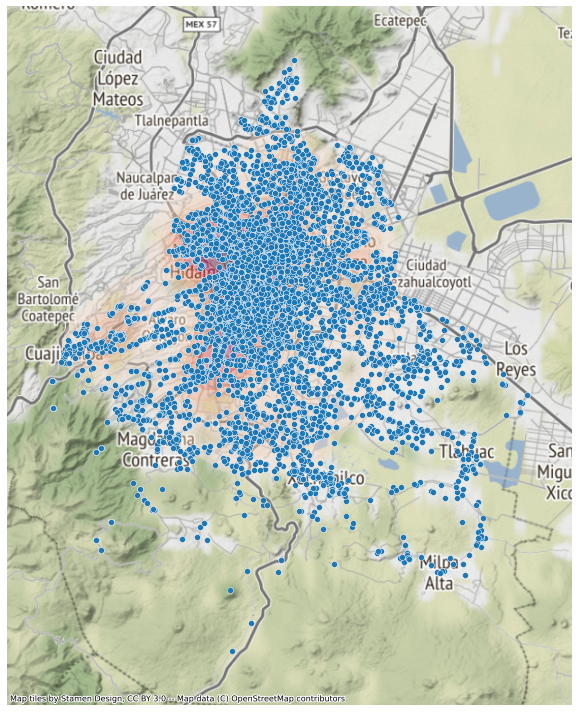

La consulta contiene: 8583 establecimientos


In [73]:
MapaDENUE("722511",region="09", puntos=True)
MapaDENUE("722511",region="09")

Un vistazo a la gráfica de puntos nos podría llevar a pensar que estos establecimientos están casi homogéneamente distribuidos en toda la Ciudad de México. Sin embargo, cuando observamossólo la gráfica con la densidad kernel, se vuelve evidente que hay una concentración muy importante en las zonas que rodean el Bosque de Chapultepec y avenida Reforma. Estas son zonas altamente frecuentadas por turistas y tienen una alta densidad de restaurantes. Por otro lado, es posible que estemos viendo el efecto de que muchos de los restaurantes de la gráfica de puntos sean fondas micro y pequeñas, mientras que en la región más centrica de la ciudad, se trata de restaurantes con un mayor número de personal ocupado.

## Conclusiones

La herramienta que se desarrolló en este proyecto permite tener una visión más clara de la distribución de los establecimientos a nivel geográfico y diferenciando el sector de actividad en distintos niveles. 

Para que esta herramienta funcione, es necesario trabajar la base de datos con SQL, pues consiste de más de 5 millones de datos, y sería ineficiente cargarlos todos en el kernel de python, pues ocuparía espacio en la memoria RAM de la computadora. 

La función para crear los mapas se desarrolló en bloques, lo que permitirá hacer cambios metodológicos y expansiones con relativa facilidad. 

Los resultados, imágenes que mapean la densidad de la actividad económica medida por el número de establecimientos y el personal ocupado de cada uno, serán de especial relevancia para futuros proyectos que buscan geolocalizar la actividad económica por municipio para focalizar acciones de política económica en las regiones menos desarrolladas del país. 

## Referencias

1. https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b
2. https://www.cienciadedatos.net/documentos/pystats02-kernel-density-estimation-kde-python.html
3. https://www.inegi.org.mx/app/mapa/denue/default.aspx